This notebook is for fixing a bug that occurs when `tkdis` is changed to be one-dimensional, with the level dimension being removed.  It is observed that the cooling rate profile is not correct.

In [1]:
%matplotlib inline
import os
import re
import io
import itertools
import pprint

from bokeh.io import output_notebook, show
from bokeh.layouts import gridplot
from bokeh.plotting import figure
from bokeh.models import Range1d, Legend
from bokeh.palettes import all_palettes

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import climatools.lblnew.bestfit_params as bestfits
from climatools.lblnew import setup_bestfit, setup_overlap
import climatools.lblnew.pipeline as pipe_lblnew
import climatools.cliradlw.setup as setup_cliradlw
import climatools.cliradlw.pipeline as pipe_cliradlw

import climatools.html.html as climahtml
from climatools.lblnew.dataio import *
from climatools.plot.plot import *


import IPython.display as display


In [2]:
def param_good():
    return {'atmpro': 'saw',
 'band': [3],
 'commitnumber': '1fa6d17',
 'molecule': {'co2': 0.0004, 'h2o': 'atmpro', 'n2o': 3.2e-07},
 'tsfc': 257}


def param_bad():
    return {'atmpro': 'saw',
 'band': [3],
 'commitnumber': '9f14b60',
 'molecule': {'co2': 0.0004, 'h2o': 'atmpro', 'n2o': 3.2e-07},
 'tsfc': 257}


In [127]:
def load_tkdis(param):
    dir_fortran = pipe_cliradlw.get_fortran_dir(param=param, 
                                                setup=setup_cliradlw)

    fpath = os.path.join(dir_fortran, 'tkdis.dat')

    df = pd.read_csv(fpath, sep=r'\s+')
    
    df = df.drop(['band', 'i'], axis=1)    
    df = df.set_index(['k1', 'k2', 'mid'])
#    df = df.set_index(['band', 'i', 'k1', 'k2', 'mid'])

    ds = xr.Dataset.from_dataframe(df)
    return ds




In [159]:
GOOD = load_tkdis(param_good())
BAD = load_tkdis(param_bad())

In [224]:
def tkdis_k1_k2bot_allgases():
    '''
    This displays the transmittance of all gases between the surface
    and each level above it.
    '''
    good = GOOD.sel(k2=76).sel(mid=4)['tkdis'].to_dataframe()
    bad = BAD.sel(k2=76).sel(mid=4)['tkdis'].to_dataframe()
    vs =  pd.concat([good, bad], axis=1, keys=['good', 'bad'])

    with pd.option_context('display.max_rows', 999):
        display.display(vs)
        display.display(display.Markdown(
            '''*TABLE.* Transmittance due to all gases 
            between the surface and each level above it. 
            k2=76. k1=0, ..., 75. mid=4'''))
        

In [225]:
def tb_k1top_k2_aftereachgas():
    good = GOOD.sel(k1=0).to_dataframe()
    bad = BAD.sel(k1=0).to_dataframe()
    
    vs = pd.concat([good, bad], axis=1, keys=['good', 'bad'])
    
    with pd.option_context('display.max_rows', 999):
        display.display(vs)
        display.display(display.Markdown(
           '''*TABLE.* k1=0. Transmittance at the end of each 
           iteration within do-loop over gases, within do-loop over k2.
           Since there are 76 k2's and 3 gases (mid=1, 2, 4),
           there are a total of 76 x 3 = 228 values.'''))

        
def plt_k1top_k2_aftereachgas():
    good = GOOD.sel(k1=0).to_dataframe()
    bad = BAD.sel(k1=0).to_dataframe()
    
    fig, ax = plt.subplots(nrows=1, ncols=1)    
    ax.plot(good['tkdis'].values, label='good')
    ax.plot(bad['tkdis'].values, label='bad')
    ax.set_ylabel('tkdis')
    ax.set_xlabel('iteration')
    ax.legend()
    
    display.display(fig)
    display.display(display.Markdown(
        '''*FIGURE.* k1 = 0. Transmittance at the end of each iteration 
        within do-loop over gases, within do-loop over k2. Since
        there are 76 k2's and 3 gases (mid=1, 2, 4),
        there are a total of 76 x 3 = 228 iterations on the x-axis.
        For the "good" line, the sharp oscillation follows the 
        do-loop over gases, while the more gradual modulation
        follows the do-loop over k2.  
        '''))
    plt.close(fig)
        


In [226]:
def script():
    tkdis_k1_k2bot_allgases()
    plt_k1top_k2_aftereachgas()
    tb_k1top_k2_aftereachgas()

good               bad                  
     k2 mid     tkdis  k2 mid         tkdis
k1                                         
0    76   4  0.261800  76   4  5.015437e-11
1    76   4  0.261800  76   4  5.015450e-11
2    76   4  0.261800  76   4  5.015709e-11
3    76   4  0.261800  76   4  5.015810e-11
4    76   4  0.261800  76   4  5.015948e-11
5    76   4  0.261800  76   4  5.016136e-11
6    76   4  0.261800  76   4  5.016391e-11
7    76   4  0.261800  76   4  5.016735e-11
8    76   4  0.261800  76   4  5.017197e-11
9    76   4  0.261800  76   4  5.017816e-11
10   76   4  0.261800  76   4  5.018639e-11
11   76   4  0.261800  76   4  5.019723e-11
12   76   4  0.261800  76   4  5.021140e-11
13   76   4  0.261800  76   4  5.022978e-11
14   76   4  0.261800  76   4  5.025347e-11
15   76   4  0.261800  76   4  5.028371e-11
16   76   4  0.261800  76   4  5.032185e-11
17   76   4  0.261800  76   4  5.036969e-11
18   76   4  0.261801  76   4  5.042973e-11
19   76   4  0.261801  76   4  5.050533e-11
20   76   4  0.261802  76   4  5.060112e-11
21   76   4  0.261803  76   4  5.072362e-11
22   76   4  0.261805  76   4  5.088290e-11
23   76   4  0.261807  76   4  5.108633e-11
24   76   4  0.261810  76   4  5.133710e-11
25   76   4  0.261814  76   4  5.164478e-11
26   76   4  0.261819  76   4  5.202870e-11
27   76   4  0.261825  76   4  5.251473e-11
28   76   4  0.261835  76   4  5.314207e-11
29   76   4  0.261848  76   4  5.397000e-11
30   76   4  0.261867  76   4  5.510163e-11
31   76   4  0.261897  76   4  5.667961e-11
32   76   4  0.261945  76   4  5.892204e-11
33   76   4  0.262021  76   4  6.217693e-11
34   76   4  0.262147  76   4  6.712680e-11
35   76   4  0.262354  76   4  7.511992e-11
36   76   4  0.262704  76   4  8.914660e-11
37   76   4  0.263262  76   4  1.150596e-10
38   76   4  0.263904  76   4  1.530368e-10
39   76   4  0.264617  76   4  2.080103e-10
40   76   4  0.265390  76   4  2.876199e-10
41   76   4  0.266222  76   4  4.032645e-10
42   76   4  0.267113  76   4  5.721307e-10
43   76   4  0.268067  76   4  8.202854e-10
44   76   4  0.269086  76   4  1.185762e-09
45   76   4  0.270169  76   4  1.724076e-09
46   76   4  0.271320  76   4  2.517144e-09
47   76   4  0.272555  76   4  3.703054e-09
48   76   4  0.273904  76   4  5.523954e-09
49   76   4  0.275390  76   4  8.377929e-09
50   76   4  0.277049  76   4  1.301642e-08
51   76   4  0.278921  76   4  2.084127e-08
52   76   4  0.281051  76   4  3.448899e-08
53   76   4  0.283497  76   4  5.919508e-08
54   76   4  0.286329  76   4  1.056739e-07
55   76   4  0.289624  76   4  1.966206e-07
56   76   4  0.293464  76   4  3.814328e-07
57   76   4  0.297948  76   4  7.716068e-07
58   76   4  0.303185  76   4  1.625828e-06
59   76   4  0.309288  76   4  3.558888e-06
60   76   4  0.316379  76   4  8.061655e-06
61   76   4  0.324595  76   4  1.880497e-05
62   76   4  0.334089  76   4  4.490470e-05
63   76   4  0.345027  76   4  1.090126e-04
64   76   4  0.357597  76   4  2.670042e-04
65   76   4  0.372020  76   4  6.545135e-04
66   76   4  0.388557  76   4  1.592721e-03
67   76   4  0.407524  76   4  3.815675e-03
68   76   4  0.429352  76   4  8.930409e-03
69   76   4  0.454579  76   4  2.024938e-02
70   76   4  0.483895  76   4  4.405741e-02
71   76   4  0.518324  76   4  9.108213e-02
72   76   4  0.559379  76   4  1.766907e-01
73   76   4  0.609839  76   4  3.174408e-01
74   76   4  0.675998  76   4  5.223126e-01
75   76   4  0.773933  76   4  7.739328e-01

*TABLE.* Transmittance due to all gases 
            between the surface and each level above it. 
            k2=76. k1=0, ..., 75. mid=4

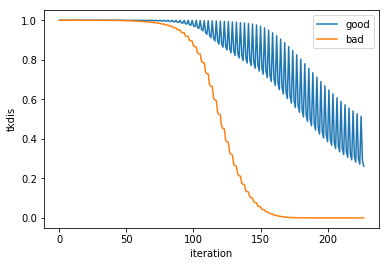

*FIGURE.* k1 = 0. Transmittance at the end of each iteration 
        within do-loop over gases, within do-loop over k2. Since
        there are 76 k2's and 3 gases (mid=1, 2, 4),
        there are a total of 76 x 3 = 228 iterations on the x-axis.
        For the "good" line, the sharp oscillation follows the 
        do-loop over gases, while the more gradual modulation
        follows the do-loop over k2.  
        

good           bad              
         k1     tkdis  k1         tkdis
k2 mid                                 
1  1      0  1.000000   0  1.000000e+00
   2      0  1.000000   0  9.999999e-01
   4      0  1.000000   0  9.999998e-01
2  1      0  1.000000   0  9.999998e-01
   2      0  0.999997   0  9.999965e-01
   4      0  0.999997   0  9.999964e-01
3  1      0  1.000000   0  9.999963e-01
   2      0  0.999995   0  9.999918e-01
   4      0  0.999995   0  9.999916e-01
4  1      0  1.000000   0  9.999915e-01
   2      0  0.999993   0  9.999850e-01
   4      0  0.999993   0  9.999848e-01
5  1      0  1.000000   0  9.999847e-01
   2      0  0.999991   0  9.999754e-01
   4      0  0.999990   0  9.999751e-01
6  1      0  1.000000   0  9.999750e-01
   2      0  0.999986   0  9.999616e-01
   4      0  0.999986   0  9.999611e-01
7  1      0  1.000000   0  9.999610e-01
   2      0  0.999980   0  9.999416e-01
   4      0  0.999980   0  9.999410e-01
8  1      0  1.000000   0  9.999408e-01
   2      0  0.999972   0  9.999126e-01
   4      0  0.999971   0  9.999118e-01
9  1      0  1.000000   0  9.999115e-01
   2      0  0.999959   0  9.998705e-01
   4      0  0.999958   0  9.998694e-01
10 1      0  1.000000   0  9.998690e-01
   2      0  0.999940   0  9.998095e-01
   4      0  0.999939   0  9.998080e-01
11 1      0  0.999999   0  9.998074e-01
   2      0  0.999913   0  9.997214e-01
   4      0  0.999911   0  9.997193e-01
12 1      0  0.999999   0  9.997185e-01
   2      0  0.999876   0  9.995950e-01
   4      0  0.999873   0  9.995920e-01
13 1      0  0.999999   0  9.995909e-01
   2      0  0.999823   0  9.994153e-01
   4      0  0.999819   0  9.994112e-01
14 1      0  0.999998   0  9.994095e-01
   2      0  0.999752   0  9.991636e-01
   4      0  0.999747   0  9.991579e-01
15 1      0  0.999997   0  9.991554e-01
   2      0  0.999660   0  9.988179e-01
   4      0  0.999652   0  9.988098e-01
16 1      0  0.999996   0  9.988062e-01
   2      0  0.999545   0  9.983556e-01
   4      0  0.999534   0  9.983444e-01
17 1      0  0.999995   0  9.983391e-01
   2      0  0.999412   0  9.977569e-01
   4      0  0.999396   0  9.977412e-01
18 1      0  0.999992   0  9.977336e-01
   2      0  0.999265   0  9.970074e-01
   4      0  0.999242   0  9.969854e-01
19 1      0  0.999989   0  9.969744e-01
   2      0  0.999110   0  9.960980e-01
   4      0  0.999079   0  9.960671e-01
20 1      0  0.999984   0  9.960514e-01
   2      0  0.998945   0  9.950165e-01
   4      0  0.998902   0  9.949733e-01
21 1      0  0.999977   0  9.949508e-01
   2      0  0.998752   0  9.937319e-01
   4      0  0.998692   0  9.936715e-01
22 1      0  0.999968   0  9.936393e-01
   2      0  0.998496   0  9.921769e-01
   4      0  0.998411   0  9.920923e-01
23 1      0  0.999954   0  9.920471e-01
   2      0  0.998148   0  9.902551e-01
   4      0  0.998029   0  9.901368e-01
24 1      0  0.999937   0  9.900748e-01
   2      0  0.997701   0  9.878608e-01
   4      0  0.997534   0  9.876954e-01
25 1      0  0.999916   0  9.876124e-01
   2      0  0.997141   0  9.848714e-01
   4      0  0.996907   0  9.846405e-01
26 1      0  0.999889   0  9.845315e-01
   2      0  0.996432   0  9.811277e-01
   4      0  0.996105   0  9.808058e-01
27 1      0  0.999856   0  9.806649e-01
   2      0  0.995521   0  9.764130e-01
   4      0  0.995065   0  9.759654e-01
28 1      0  0.999816   0  9.757858e-01
   2      0  0.994305   0  9.704076e-01
   4      0  0.993670   0  9.697877e-01
29 1      0  0.999766   0  9.695608e-01
   2      0  0.992623   0  9.626333e-01
   4      0  0.991742   0  9.617794e-01
30 1      0  0.999703   0  9.614940e-01
   2      0  0.990226   0  9.523788e-01
   4      0  0.989012   0  9.512114e-01
31 1      0  0.999624   0  9.508533e-01
   2      0  0.986922   0  9.387715e-01
   4      0  0.985260   0  9.371909e-01
32 1      0  0.999522   0  9.367426e-01
   2      0  0.982653   0  9.209335e-01
   4      0  0.980397   0  9.188187e-01
33 1      0  0.999390   0  9.182579e-01
   2   

*TABLE.* k1=0. Transmittance at the end of each 
           iteration within do-loop over gases, within do-loop over k2.
           Since there are 76 k2's and 3 gases (mid=1, 2, 4),
           there are a total of 76 x 3 = 228 values.

In [227]:
script()

In [228]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')